## Linear Programming

1. https://www.youtube.com/watch?v=7yZ5xxdkTb8
2. http://benalexkeen.com/linear-programming-with-python-and-pulp-part-1/


In [1]:
import numpy as np

import pulp
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pulp.pulpTestAll()

	 Testing zero subtraction
	 Testing inconsistant lp solution
	 Testing continuous LP solution
	 Testing maximize continuous LP solution
	 Testing unbounded continuous LP solution
	 Testing Long Names
	 Testing repeated Names
	 Testing zero constraint
	 Testing zero objective
	 Testing LpVariable (not LpAffineExpression) objective
	 Testing Long lines in LP
	 Testing LpAffineExpression divide
	 Testing MIP solution
	 Testing MIP solution with floats in objective
	 Testing MIP relaxation
	 Testing feasibility problem (no objective)
	 Testing an infeasible problem
	 Testing an integer infeasible problem
	 Testing column based modelling
	 Testing dual variables and slacks reporting
	 Testing fractional constraints
	 Testing elastic constraints (no change)
	 Testing elastic constraints (freebound)
	 Testing elastic constraints (penalty unchanged)
	 Testing elastic constraints (penalty unbounded)
* Solver <class 'pulp.solvers.PULP_CBC_CMD'> passed.
Solver <class 'pulp.solvers.CPLEX_DLL'> un

In [3]:
# x > 0
x = np.linspace(0, 20, 2000)
# y >= 2
y1 = (x*0) + 2
# 2y <= 25 - x
y2 = (25-x)/2.0
# 4y >= 2x - 8 
y3 = (2*x-8)/4.0
# y <= 2x - 5 
y4 = 2 * x -5


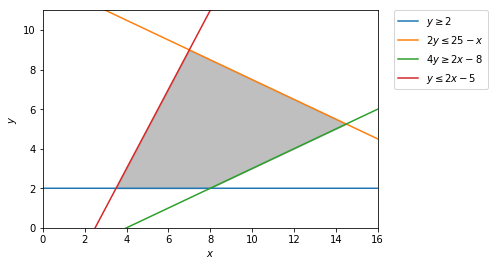

In [4]:
plt.plot(x, y1, label=r'$y\geq2$')
plt.plot(x, y2, label=r'$2y\leq25-x$')
plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
plt.plot(x, y4, label=r'$y\leq 2x-5$')
plt.xlim((0, 16))
plt.ylim((0, 11))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
y5 = np.minimum(y2, y4)
y6 = np.maximum(y1, y3)
plt.fill_between(x, y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [5]:
# Now the same thing as pulp
lp_problem = pulp.LpProblem("My LP Problem", pulp.LpMaximize)
x = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y = pulp.LpVariable('y', lowBound=2, cat='Continuous')
# Objective function
lp_problem += 4 * x + 3 * y, "Z"

# Constraints
lp_problem += 2 * y <= 25 - x
lp_problem += 4 * y >= 2 * x - 8
lp_problem += y <= 2 * x - 5

In [6]:
lp_problem

My LP Problem:
MAXIMIZE
4*x + 3*y + 0
SUBJECT TO
_C1: x + 2 y <= 25

_C2: - 2 x + 4 y >= -8

_C3: - 2 x + y <= -5

VARIABLES
x Continuous
2 <= y Continuous

In [7]:
lp_problem.solve()
pulp.LpStatus[lp_problem.status]

'Optimal'

In [8]:
for variable in lp_problem.variables():
    print("{} = {}".format(variable.name, variable.varValue))

x = 14.5
y = 5.25


In [9]:
print(pulp.value(lp_problem.objective))

73.75


In [10]:
books_df = pd.read_csv('../reading/goodread_books.csv')
# books_df = books_df.sample(50)

In [11]:
books_df.head()

,title,num_review,num_ratings,url,rating,num_pages,genres
0,to kill a mockingbird,75722,3504156,https://www.goodreads.com/book/show/2657.To_Ki...,4.26,324.0,"classics,fiction,historical"
1,of mice and men,26309,1592170,https://www.goodreads.com/book/show/890.Of_Mic...,3.85,112.0,"fiction,classics,academic"
2,the giver,56313,1382912,https://www.goodreads.com/book/show/3636.The_G...,4.12,208.0,"fiction,childrens,classics"
3,alice's adventures in wonderland & through the...,8160,389142,https://www.goodreads.com/book/show/24213.Alic...,4.06,239.0,"classics,fantasy,fiction"
4,the catcher in the rye,47062,2232015,https://www.goodreads.com/book/show/7933650-th...,3.80,230.0,"classics,fiction,young adult"


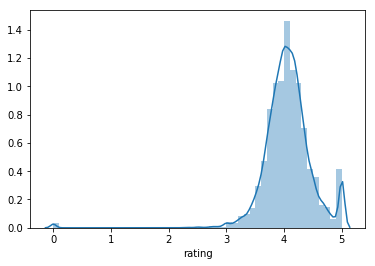

In [12]:
sns.distplot(books_df['rating'])

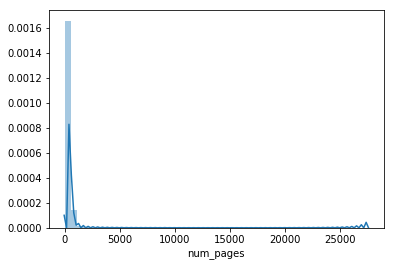

In [13]:
sns.distplot(books_df.num_pages.dropna())

In [14]:
# create the LP object
# Maximization problem we want to maximize the number of books we read in 100 hours
prob = pulp.LpProblem('RecommendedBooks', pulp.LpMaximize)

In [15]:
#I would not like to read a book more than 1200 pages
books_df = books_df.dropna(subset=['num_pages', 'title', 'rating', 'genres'])

In [16]:
books_df.shape

(14039, 7)

In [17]:
books_df = books_df[(books_df.num_pages <= 1200) & 
                    (books_df.num_pages > 20) &
                    (books_df.rating > 3.5) &
                    (books_df.num_ratings > 10000) &
                    (books_df.num_review > 1000) &
                    (~books_df.genres.str.contains('children'))
                   ]
books_df = books_df.drop_duplicates(subset=['title'])

In [18]:
books_df.shape

(3472, 7)

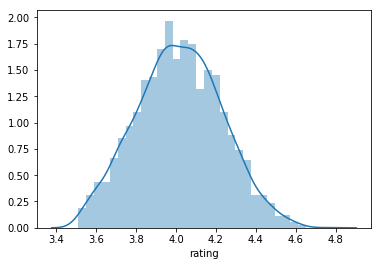

In [19]:
sns.distplot(books_df['rating'])

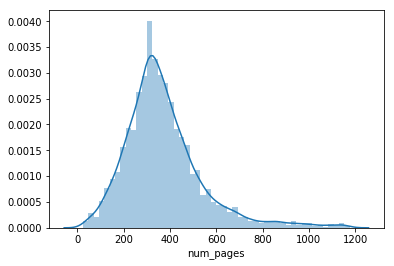

In [20]:
sns.distplot(books_df.num_pages.dropna())

In [21]:
decision_variables = {}
for rownumber, row in books_df.iterrows():
    variable = str('x' + str(rownumber))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer')
    decision_variables[rownumber] = variable
print("Total number of decision_variables: " + str(len(decision_variables)))

Total number of decision_variables: 3472


In [22]:
#create optimization function
total_books = ""
for i, book in decision_variables.items():
    total_books += book * books_df.loc[i, 'rating']

prob += total_books
print("Optimization function: " + str(total_books))

Optimization function: 4.26*x0 + 3.85*x1 + 4.04*x10 + 3.7*x100 + 4.22*x10009 + 3.87*x1001 + 4.04*x10014 + 3.96*x10015 + 3.97*x1002 + 3.97*x10022 + 4.39*x1003 + 3.91*x10032 + 3.98*x10044 + 3.96*x10056 + 4.14*x10063 + 4.13*x10066 + 4.49*x10081 + 4.36*x1009 + 3.77*x10095 + 4.12*x10119 + 4.11*x10127 + 3.82*x10128 + 4.56*x10131 + 3.95*x10137 + 3.58*x1014 + 4.16*x10140 + 4.42*x1015 + 3.8*x1016 + 4.07*x10169 + 4.32*x1017 + 4.27*x10174 + 3.76*x10193 + 3.98*x10198 + 4.02*x102 + 3.77*x1020 + 3.76*x10202 + 4.2*x1022 + 3.84*x10231 + 3.97*x10239 + 3.73*x10242 + 4.55*x10249 + 3.88*x1025 + 3.91*x10274 + 3.81*x10278 + 4.29*x1028 + 4.17*x10283 + 4.07*x10288 + 3.92*x10291 + 3.71*x10296 + 4.01*x103 + 3.91*x1031 + 4.13*x10339 + 3.93*x1034 + 4.11*x10357 + 4.0*x1036 + 4.07*x10365 + 4.21*x10376 + 4.03*x1038 + 4.21*x10383 + 3.83*x1039 + 4.06*x104 + 4.13*x10406 + 3.98*x10419 + 4.21*x10432 + 4.44*x10443 + 4.13*x10459 + 4.12*x1046 + 3.62*x1047 + 3.9*x10474 + 4.32*x10476 + 3.98*x1048 + 4.25*x10480 + 3.63*x10485 +

In [23]:
total_hours_to_read = 100
pages_per_hour = 60
total_pages_can_read = total_hours_to_read * pages_per_hour

In [24]:
prob

RecommendedBooks:
MAXIMIZE
4.26*x0 + 3.85*x1 + 4.04*x10 + 3.7*x100 + 4.22*x10009 + 3.87*x1001 + 4.04*x10014 + 3.96*x10015 + 3.97*x1002 + 3.97*x10022 + 4.39*x1003 + 3.91*x10032 + 3.98*x10044 + 3.96*x10056 + 4.14*x10063 + 4.13*x10066 + 4.49*x10081 + 4.36*x1009 + 3.77*x10095 + 4.12*x10119 + 4.11*x10127 + 3.82*x10128 + 4.56*x10131 + 3.95*x10137 + 3.58*x1014 + 4.16*x10140 + 4.42*x1015 + 3.8*x1016 + 4.07*x10169 + 4.32*x1017 + 4.27*x10174 + 3.76*x10193 + 3.98*x10198 + 4.02*x102 + 3.77*x1020 + 3.76*x10202 + 4.2*x1022 + 3.84*x10231 + 3.97*x10239 + 3.73*x10242 + 4.55*x10249 + 3.88*x1025 + 3.91*x10274 + 3.81*x10278 + 4.29*x1028 + 4.17*x10283 + 4.07*x10288 + 3.92*x10291 + 3.71*x10296 + 4.01*x103 + 3.91*x1031 + 4.13*x10339 + 3.93*x1034 + 4.11*x10357 + 4.0*x1036 + 4.07*x10365 + 4.21*x10376 + 4.03*x1038 + 4.21*x10383 + 3.83*x1039 + 4.06*x104 + 4.13*x10406 + 3.98*x10419 + 4.21*x10432 + 4.44*x10443 + 4.13*x10459 + 4.12*x1046 + 3.62*x1047 + 3.9*x10474 + 4.32*x10476 + 3.98*x1048 + 4.25*x10480 + 3.63*x104

In [25]:
#create constrains - there are only 365 days

total_pages_needs_to_read = ""
for rownum, row in books_df.iterrows():
    formula = row['num_pages']* decision_variables[rownum]
    total_pages_needs_to_read += formula

prob += (total_pages_needs_to_read == total_pages_can_read)

In [26]:
print(prob)
prob.writeLP("RecommendedBooks3.lp" )

RecommendedBooks:
MAXIMIZE
4.26*x0 + 3.85*x1 + 4.04*x10 + 3.7*x100 + 4.22*x10009 + 3.87*x1001 + 4.04*x10014 + 3.96*x10015 + 3.97*x1002 + 3.97*x10022 + 4.39*x1003 + 3.91*x10032 + 3.98*x10044 + 3.96*x10056 + 4.14*x10063 + 4.13*x10066 + 4.49*x10081 + 4.36*x1009 + 3.77*x10095 + 4.12*x10119 + 4.11*x10127 + 3.82*x10128 + 4.56*x10131 + 3.95*x10137 + 3.58*x1014 + 4.16*x10140 + 4.42*x1015 + 3.8*x1016 + 4.07*x10169 + 4.32*x1017 + 4.27*x10174 + 3.76*x10193 + 3.98*x10198 + 4.02*x102 + 3.77*x1020 + 3.76*x10202 + 4.2*x1022 + 3.84*x10231 + 3.97*x10239 + 3.73*x10242 + 4.55*x10249 + 3.88*x1025 + 3.91*x10274 + 3.81*x10278 + 4.29*x1028 + 4.17*x10283 + 4.07*x10288 + 3.92*x10291 + 3.71*x10296 + 4.01*x103 + 3.91*x1031 + 4.13*x10339 + 3.93*x1034 + 4.11*x10357 + 4.0*x1036 + 4.07*x10365 + 4.21*x10376 + 4.03*x1038 + 4.21*x10383 + 3.83*x1039 + 4.06*x104 + 4.13*x10406 + 3.98*x10419 + 4.21*x10432 + 4.44*x10443 + 4.13*x10459 + 4.12*x1046 + 3.62*x1047 + 3.9*x10474 + 4.32*x10476 + 3.98*x1048 + 4.25*x10480 + 3.63*x104

In [27]:
pulp.LpSolverDefault.msg = 1

In [28]:
#now run optimization
optimization_result = prob.solve()
assert optimization_result == pulp.LpStatusOptimal
print("Status of the solution:", pulp.LpStatus[prob.status])
print("Number of books in the suggested list: ", pulp.value(prob.objective))

Status of the solution: Optimal
Number of books in the suggested list:  315.71999999999997


In [29]:
var_name = []
var_value = []

for v in prob.variables():
    var_name.append(v.name)
    var_value.append(v.varValue)
df = pd.DataFrame({'row_num': var_name, 'value': var_value})

In [30]:
df.shape

(3472, 2)

In [31]:
df['row_num'] = df.row_num.str.replace('x', '').astype(int)

In [32]:
df = df[df.value == 1]

In [33]:
df.shape

(78, 2)

In [34]:
result_df = books_df.loc[df.row_num.tolist()].copy()

In [35]:
result_df.shape[0]

78

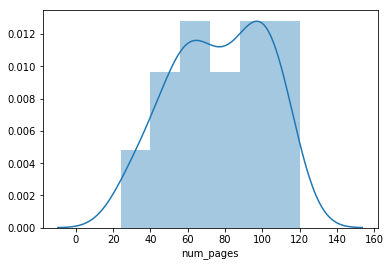

In [36]:
sns.distplot(result_df.num_pages)

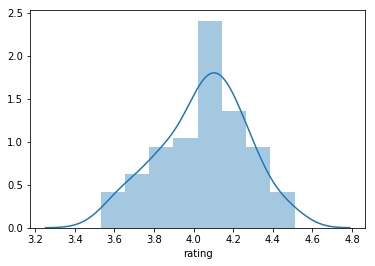

In [37]:
sns.distplot(result_df.rating)

In [38]:
result_df = result_df.sort_values(ascending=False, by=['rating', 'num_ratings'])

In [39]:
result_df.to_csv('./v4_reading_list.csv', index=False)

In [40]:
result_df.url.head(10).tolist()

['https://www.goodreads.com/book/show/5153799-father-mine',
 'https://www.goodreads.com/book/show/464260.The_Fire_Next_Time',
 'https://www.goodreads.com/book/show/22738563-we-should-all-be-feminists',
 'https://www.goodreads.com/book/show/13605727-elixir',
 'https://www.goodreads.com/book/show/96358.Batman',
 'https://www.goodreads.com/book/show/46199.Letters_to_a_Young_Poet',
 'https://www.goodreads.com/book/show/5932.Twenty_Love_Poems_and_a_Song_of_Despair',
 'https://www.goodreads.com/book/show/1617.Night',
 'https://www.goodreads.com/book/show/81959.As_a_Man_Thinketh',
 'https://www.goodreads.com/book/show/59151.Chess_Story']